In [135]:
# Importar Librerias
import pandas as pd
import kaggle

In [136]:
# Obtenemos los dataset con la API de Kaggle
kaggle.api.dataset_download_files(
    "olistbr/brazilian-ecommerce",
    path="data",
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


In [137]:
# Obtenemos los dataframes a analizar

order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
categories = pd.read_csv("data/product_category_name_translation.csv")

In [138]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [139]:
orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-08-02 12:06:07,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [140]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [141]:
products.describe()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [142]:
categories.describe()

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


In [143]:
#Filtramos las ordenes que fueron entregadas
orders = orders[orders["order_status"] == "delivered"]
orders = orders[
    ["order_id", "order_purchase_timestamp"]
]

order_items = order_items[
    ["order_id", "product_id", "price", "freight_value"]
]

products = products[
    ["product_id", "product_category_name"]
]

In [144]:
df = orders.merge(
    order_items,
    on="order_id",
    how="inner"
)

In [145]:
df = df.merge(
    products,
    on="product_id",
    how="left"
)

In [146]:
df = df.merge(
    categories,
    on="product_category_name",
    how="left"
)

In [147]:
df["order_purchase_timestamp"] = pd.to_datetime(
    df["order_purchase_timestamp"]
)

In [148]:
df.duplicated().sum()

np.int64(10001)

In [149]:
df.isnull().sum()

,0
order_id,0
order_purchase_timestamp,0
product_id,0
price,0
freight_value,0
product_category_name,1537
product_category_name_english,1559


In [150]:
df["product_category_name_english"] = df[
    "product_category_name_english"
].fillna("unknown")

In [151]:
df = df.dropna(subset=["price"])

In [152]:
df_final = df[
    [
        "order_purchase_timestamp",
        "order_id",
        "product_id",
        "product_category_name_english",
        "price",
        "freight_value"
    ]
]

In [153]:
df_final.to_csv("tabla_analitica_olist.csv", index=False)

In [154]:
df_final.head(10)

,order_purchase_timestamp,order_id,product_id,product_category_name_english,price,freight_value
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,housewares,29.99,8.72
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,perfumery,118.70,22.76
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,auto,159.90,19.22
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,45.00,27.20
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,stationery,19.90,8.72
5,2017-07-09 21:57:05,a4591c265e18cb1dcee52889e2d8acc3,060cb19345d90064d1015407193c233d,auto,147.90,27.36
6,2017-05-16 13:10:30,6514b8ad8028c9f2cc2374ded245783f,4520766ec412348b8d4caa5e8a18c464,auto,59.99,15.17
7,2017-01-23 18:29:09,76c6e866289321a7c93b82b54852dc33,ac1789e492dcd698c5c10b97a671243a,furniture_decor,19.90,16.05
8,2017-07-29 11:55:02,e69bfb5eb88e0ed6a785585b27e16dbf,9a78fb9862b10749a117f7fc3c31f051,office_furniture,149.99,19.77
9,2017-05-16 19:41:10,e6ce16cb79ec1d90b1da9085a6118aeb,08574b074924071f4e201e151b152b4e,garden_tools,99.00,30.53


In [155]:
df_final.groupby(["order_id", "product_id"]).size()

,,0
order_id,product_id,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1
...,...,...
fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1
fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1
fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1


In [156]:
df_final["date"] = df_final["order_purchase_timestamp"].dt.date

In [157]:
demanda_diaria = (
    df_final
    .groupby(["date", "product_id", "product_category_name_english"])
    .size()
    .reset_index(name="quantity")
)

In [158]:
demanda_diaria.head(10)

,date,product_id,product_category_name_english,quantity
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3
1,2016-10-03,107177bf61755f05c604fe57e02467d6,furniture_decor,1
2,2016-10-03,3ae08df6bcbfe23586dd431c40bddbb7,watches_gifts,1
3,2016-10-03,a5c3ddb1a400f50d1cf7138727aec136,toys,1
4,2016-10-03,b72b39418216e944bb34e35f4d3ea8c7,sports_leisure,1
5,2016-10-03,bfce5e847034e1fbbc1ed0bff6a372c7,furniture_decor,1
6,2016-10-03,e2a1d45a73dc7f5a7f9236b043431b89,fashion_shoes,1
7,2016-10-03,fd7fd78fd3cbc1b0a6370a7909c0a629,sports_leisure,1
8,2016-10-04,062619359d5f9a664606cb2a6ccb477a,health_beauty,1
9,2016-10-04,0c5801458e74f9b6c23b44c331426e30,cool_stuff,1


In [159]:
ventas_diarias = (
    df_final
    .groupby(["date", "product_id", "product_category_name_english"])
    .agg(
        quantity=("product_id", "count"),
        total_sales=("price", "sum")
    )
    .reset_index()
)

In [160]:
ventas_diarias.head(10)

,date,product_id,product_category_name_english,quantity,total_sales
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3,134.97
1,2016-10-03,107177bf61755f05c604fe57e02467d6,furniture_decor,1,119.90
2,2016-10-03,3ae08df6bcbfe23586dd431c40bddbb7,watches_gifts,1,29.90
3,2016-10-03,a5c3ddb1a400f50d1cf7138727aec136,toys,1,128.90
4,2016-10-03,b72b39418216e944bb34e35f4d3ea8c7,sports_leisure,1,36.49
5,2016-10-03,bfce5e847034e1fbbc1ed0bff6a372c7,furniture_decor,1,74.90
6,2016-10-03,e2a1d45a73dc7f5a7f9236b043431b89,fashion_shoes,1,29.99
7,2016-10-03,fd7fd78fd3cbc1b0a6370a7909c0a629,sports_leisure,1,21.90
8,2016-10-04,062619359d5f9a664606cb2a6ccb477a,health_beauty,1,136.90
9,2016-10-04,0c5801458e74f9b6c23b44c331426e30,cool_stuff,1,89.90


In [161]:
demanda_diaria["date"] = pd.to_datetime(demanda_diaria["date"])

In [162]:
demanda_diaria["week"] = demanda_diaria["date"].dt.to_period("W").apply(lambda r: r.start_time)

In [163]:
demanda_semanal = (
    demanda_diaria
    .groupby(
        ["week", "product_id", "product_category_name_english"]
    )
    .agg(
        weekly_quantity=("quantity", "sum")
    )
    .reset_index()
)

In [164]:
demanda_semanal.head(10)

,week,product_id,product_category_name_english,weekly_quantity
0,2016-09-12,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3
1,2016-10-03,027cdd14a677a5834bc67a9789db5021,perfumery,1
2,2016-10-03,0534940d69bf94dc61c0e722b4168235,furniture_decor,1
3,2016-10-03,05fca08b4d54ab5d1d371db7d5534136,computers_accessories,1
4,2016-10-03,062619359d5f9a664606cb2a6ccb477a,health_beauty,1
5,2016-10-03,0980718a7bdcf89f5848b202b6394965,health_beauty,1
6,2016-10-03,09b590ada623ecf66329917ea4731957,watches_gifts,1
7,2016-10-03,0ab80f38a21093b448518f68efe82c24,housewares,1
8,2016-10-03,0b230f10ac2cfc4c831b825bf31a5de2,pet_shop,1
9,2016-10-03,0c5801458e74f9b6c23b44c331426e30,cool_stuff,1


In [165]:
demanda_semanal.shape

(77713, 4)

In [166]:
demanda_semanal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77713 entries, 0 to 77712
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   week                           77713 non-null  datetime64[ns]
 1   product_id                     77713 non-null  object        
 2   product_category_name_english  77713 non-null  object        
 3   weekly_quantity                77713 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.4+ MB


In [167]:
demanda_semanal.head()

,week,product_id,product_category_name_english,weekly_quantity
0,2016-09-12,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3
1,2016-10-03,027cdd14a677a5834bc67a9789db5021,perfumery,1
2,2016-10-03,0534940d69bf94dc61c0e722b4168235,furniture_decor,1
3,2016-10-03,05fca08b4d54ab5d1d371db7d5534136,computers_accessories,1
4,2016-10-03,062619359d5f9a664606cb2a6ccb477a,health_beauty,1


In [168]:
demanda_semanal["week"].nunique()

91

In [169]:
demanda_semanal["week"].min(), demanda_semanal["week"].max()

(Timestamp('2016-09-12 00:00:00'), Timestamp('2018-08-27 00:00:00'))

In [170]:
demanda_semanal.isnull().sum()

,0
week,0
product_id,0
product_category_name_english,0
weekly_quantity,0


In [171]:
demanda_semanal["weekly_quantity"].describe()

,weekly_quantity
count,77713.000000
mean,1.418000
std,1.381524
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,59.000000


In [172]:
demanda_semanal["product_id"].nunique()

32216

In [173]:
demanda_semanal["product_category_name_english"].nunique()

72

In [174]:
demanda_semanal.groupby(
    "product_category_name_english"
)["weekly_quantity"].sum().sort_values(ascending=False).head(10)

,weekly_quantity
product_category_name_english,
bed_bath_table,10953
health_beauty,9465
sports_leisure,8431
furniture_decor,8160
computers_accessories,7644
housewares,6795
watches_gifts,5859
telephony,4430
garden_tools,4268


In [175]:
demanda_semanal.groupby(
    "product_id"
)["weekly_quantity"].sum().sort_values(ascending=False).head(10)

,weekly_quantity
product_id,
aca2eb7d00ea1a7b8ebd4e68314663af,520
422879e10f46682990de24d770e7f83d,484
99a4788cb24856965c36a24e339b6058,477
389d119b48cf3043d311335e499d9c6b,390
368c6c730842d78016ad823897a372db,388
53759a2ecddad2bb87a079a1f1519f73,373
d1c427060a0f73f6b889a5c7c61f2ac4,332
53b36df67ebb7c41585e8d54d6772e08,321
154e7e31ebfa092203795c972e5804a6,274


**Analisis exploratorio de datos (EDA).**

### Analisis Univariante

Cabe destacar que las medidas de tendencia central y dispersión, así como visualizaciones como histogramas o diagramas de caja, solo son aplicables a variables numéricas. En el caso de las variables categóricas analizadas, el estudio se centra en la distribución de frecuencias y en la identificación de valores predominantes.

In [176]:
def analisis_univariado(variable:str, data:pd.DataFrame,ntop:int):

    print(f"Análisis univariado de {variable}")

    n = data[variable].nunique()
    ndata = data.shape[0]
    print(f'El número de valores únicos es: {n}')

    print('\nTabla de frecuencias absolutas y relativas')
    table_count = data[variable].value_counts().reset_index()
    table_count['Pct'] = (table_count['count'] / ndata)*100
    table_count = table_count.sort_values(ascending=False, by ='count')
    display(table_count.head(10))

    # Top N valores más frecuentes
    table_top = table_count[[variable,'count']].head(ntop)

    # Gráfico de barras
    print(f'\nGráfico de barras del top {ntop} de {variable}')
    table_top.sort_values(by=variable, ascending=True).set_index(variable)['count'].plot(kind='bar', colormap='viridis')
    plt.ylabel('Número de Títulos')
    plt.xlabel(variable)
    plt.show()

#### Price

In [177]:
import matplotlib.pyplot as plt

In [178]:
df_final['price'].describe()

,price
count,110197.000000
mean,119.980563
std,182.299446
min,0.850000
25%,39.900000
50%,74.900000
75%,134.170000
max,6735.000000


Las estadísticas descriptivas del precio permiten identificar el rango de valores presentes en el dataset, así como las medidas de tendencia central y dispersión. La diferencia entre la media y la mediana evidencia una distribución asimétrica, mientras que los valores mínimo y máximo reflejan la heterogeneidad del catálogo de productos.

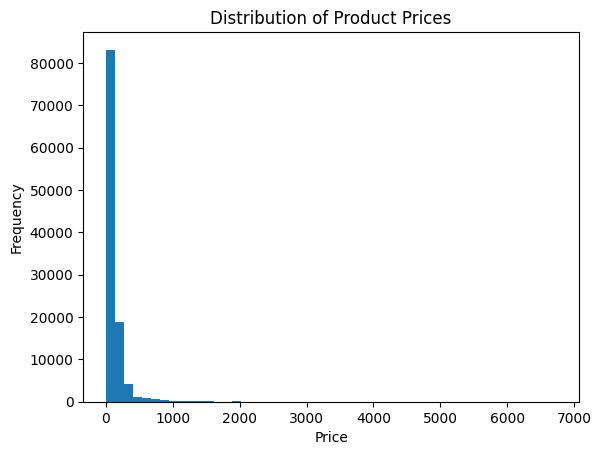

In [179]:
plt.figure()
plt.hist(df_final['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')
plt.show()

El histograma del precio muestra una alta concentración de observaciones en rangos de precio bajos, con una cola extendida hacia valores más elevados. Esta distribución asimétrica sugiere que la mayoría de los productos vendidos son de bajo precio, mientras que un número reducido corresponde a productos de mayor valor.

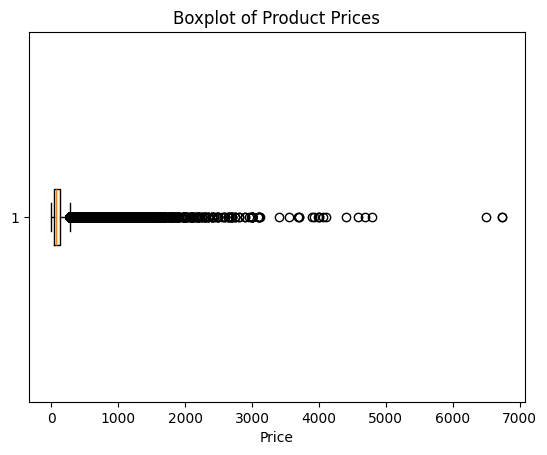

In [180]:
plt.figure()
plt.boxplot(df_final['price'], vert=False)
plt.xlabel('Price')
plt.title('Boxplot of Product Prices')
plt.show()

El boxplot del precio permite identificar la presencia de valores atípicos, representados por observaciones alejadas del rango intercuartílico. Estos valores no se consideran errores, sino una característica esperable en un entorno de comercio electrónico con productos de distinto valor económico.

In [181]:
Q1 = df_final['price'].quantile(0.25)
Q3 = df_final['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_price = df_final[
    (df_final['price'] < lower_bound) |
    (df_final['price'] > upper_bound)
]

outliers_price.shape[0]

8162

La identificación de valores atípicos se realizó mediante el método del rango intercuartílico (IQR), lo que permitió cuantificar la cantidad de observaciones extremas sin excluirlas del análisis, preservando así la información real del mercado.

### freight_value

In [182]:
df_final['freight_value'].describe()

,freight_value
count,110197.000000
mean,19.948598
std,15.698136
min,0.000000
25%,13.080000
50%,16.260000
75%,21.150000
max,409.680000


Las estadísticas descriptivas del costo de envío evidencian una elevada dispersión y un amplio rango de valores, lo que refleja la variabilidad logística inherente al comercio electrónico.

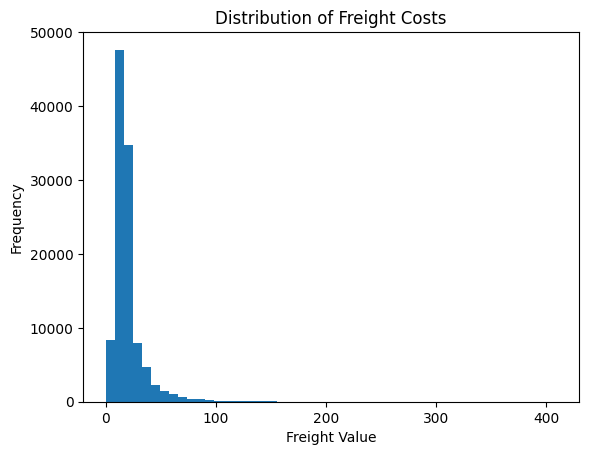

In [183]:
plt.figure()
plt.hist(df_final['freight_value'], bins=50)
plt.xlabel('Freight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Freight Costs')
plt.show()

El histograma del costo de envío muestra una fuerte concentración de valores bajos y una cola prolongada hacia valores elevados, indicando una distribución altamente asimétrica. Este comportamiento es consistente con diferencias logísticas entre productos y ubicaciones.

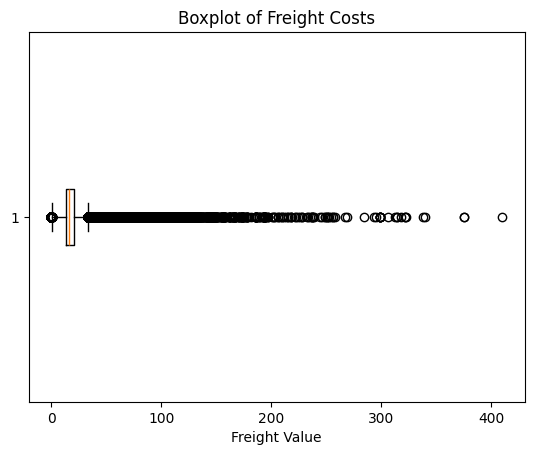

In [184]:
plt.figure()
plt.boxplot(df_final['freight_value'], vert=False)
plt.xlabel('Freight Value')
plt.title('Boxplot of Freight Costs')
plt.show()

El boxplot del costo de envío permite visualizar la elevada variabilidad del flete, así como la presencia de valores extremos, los cuales representan envíos con mayores costos logísticos y no errores de registro.

In [185]:
df_final['freight_value'].std()

15.698136099019289

La desviación estándar del costo de envío refuerza la existencia de una alta variabilidad, lo que sugiere heterogeneidad en las condiciones de entrega.

### Análisis Bivariante

#### Price vs Product Category Name English

¿Existen diferencias significativas en los precios de los productos según su categoría?

In [186]:
df_final.groupby('product_category_name_english')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category_name_english,,,,,,,,
agro_industry_and_commerce,206.0,342.553883,424.010065,12.99,35.00,243.75,420.00,2990.00
air_conditioning,289.0,184.510588,189.799072,10.90,75.90,139.99,199.00,1599.00
art,197.0,120.087817,458.705181,5.35,55.00,99.90,99.99,6499.00
arts_and_craftmanship,24.0,75.583750,73.997815,9.80,19.60,44.90,127.24,289.49
audio,362.0,139.697790,159.988774,14.90,19.90,89.00,175.00,598.99
...,...,...,...,...,...,...,...,...
tablets_printing_image,83.0,90.703735,93.096747,14.90,54.90,99.00,99.00,889.99
telephony,4430.0,69.945876,133.891395,5.00,21.99,29.99,49.00,2428.00
toys,4030.0,116.944536,131.586770,4.90,45.99,79.90,129.90,1699.99


El análisis descriptivo por categoría permite comparar las medidas de tendencia central y dispersión del precio entre los distintos tipos de productos. Este resumen evidencia diferencias relevantes en los niveles de precio promedio y en la variabilidad entre categorías, lo que sugiere una estructura de precios diferenciada según el tipo de producto.

<Figure size 1200x600 with 0 Axes>

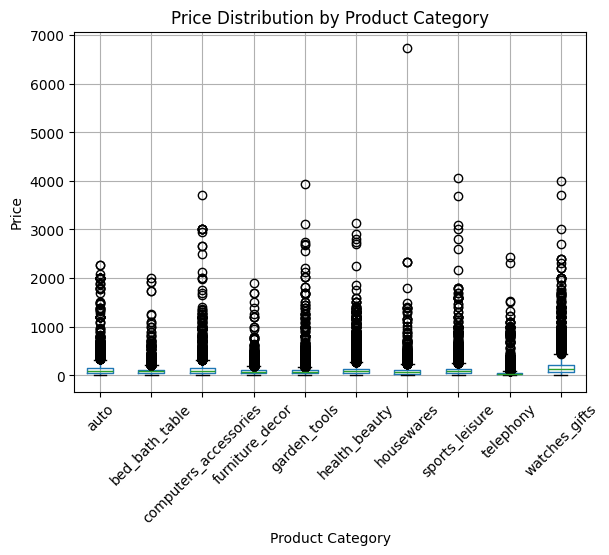

In [187]:
top_categories = df_final['product_category_name_english'].value_counts().head(10).index

df_top = df_final[df_final['product_category_name_english'].isin(top_categories)]

plt.figure(figsize=(12,6))
df_top.boxplot(column='price', by='product_category_name_english', rot=45)
plt.title('Price Distribution by Product Category')
plt.suptitle('')
plt.xlabel('Product Category')
plt.ylabel('Price')
plt.show()

El boxplot de precios por categoría permite visualizar claramente las diferencias en la distribución de precios entre los distintos tipos de productos. Se observan categorías con medianas significativamente más altas, así como diferencias en la dispersión y presencia de valores extremos, lo que confirma que el precio depende en gran medida de la categoría del producto.

In [188]:
mean_price_category = (
    df_final.groupby('product_category_name_english')['price']
    .mean()
    .sort_values(ascending=False)
)

mean_price_category.head(10)

,price
product_category_name_english,
computers,1098.915276
small_appliances_home_oven_and_coffee,638.213151
home_appliances_2,467.333117
agro_industry_and_commerce,342.553883
musical_instruments,283.127097
small_appliances,277.741824
fixed_telephony,216.922392
construction_tools_safety,211.875519
watches_gifts,199.040276


El análisis bivariante entre el precio y la categoría del producto demuestra la existencia de diferencias significativas en los niveles de precios según el tipo de producto. Algunas categorías presentan precios medianos y promedios considerablemente más elevados, así como mayor dispersión, lo que refleja una estructura de precios diferenciada propia de un catálogo heterogéneo. Estos resultados confirman que la categoría del producto es un factor relevante en la determinación del precio.

#### Freight Value vs Product Category Name English


¿Existen diferencias en los costos de envío según el tipo de producto?

In [189]:
df_final.groupby('product_category_name_english')['freight_value'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category_name_english,,,,,,,,
agro_industry_and_commerce,206.0,27.365049,22.254381,7.39,15.1400,23.495,30.1500,194.55
air_conditioning,289.0,22.598581,14.151886,6.58,15.2300,18.390,25.8400,115.43
art,197.0,19.432640,17.397947,7.39,12.2300,15.100,23.2800,227.66
arts_and_craftmanship,24.0,15.422083,12.267814,7.39,9.1000,12.865,15.7975,68.72
audio,362.0,15.703646,6.501574,4.25,12.6975,15.230,18.2300,52.67
...,...,...,...,...,...,...,...,...
tablets_printing_image,83.0,14.773494,5.723715,1.71,9.4400,14.860,16.3900,34.49
telephony,4430.0,15.652910,7.824388,0.01,11.0200,15.100,18.2300,121.22
toys,4030.0,18.802625,13.306924,0.01,12.8375,16.110,19.6875,193.76


El análisis descriptivo del costo de envío por categoría permite comparar las medidas de tendencia central y dispersión entre los distintos tipos de productos. Los resultados muestran diferencias relevantes tanto en los costos promedio como en la variabilidad del flete, lo que sugiere que el tipo de producto influye en las condiciones logísticas de entrega.

<Figure size 1200x600 with 0 Axes>

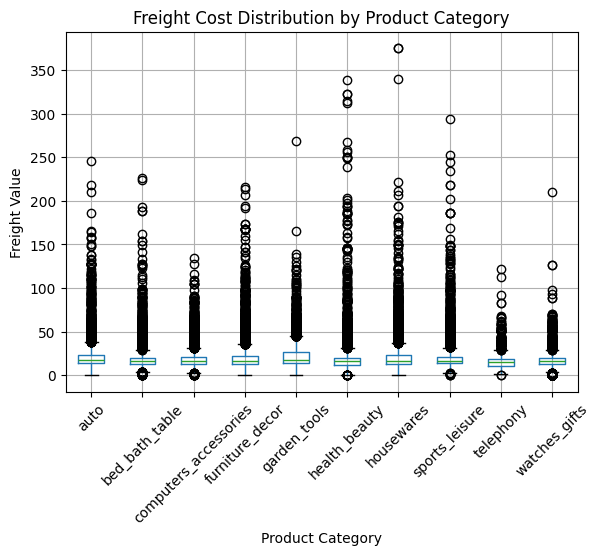

In [190]:
top_categories = df_final['product_category_name_english'].value_counts().head(10).index
df_top = df_final[df_final['product_category_name_english'].isin(top_categories)]

plt.figure(figsize=(12,6))
df_top.boxplot(column='freight_value', by='product_category_name_english', rot=45)
plt.title('Freight Cost Distribution by Product Category')
plt.suptitle('')
plt.xlabel('Product Category')
plt.ylabel('Freight Value')
plt.show()

El boxplot del costo de envío por categoría evidencia diferencias claras en la distribución del flete entre los distintos tipos de productos. Algunas categorías presentan costos medianos más elevados y mayor dispersión, lo que puede estar asociado a factores como peso, volumen o complejidad logística.

In [191]:
mean_freight_category = (
    df_final.groupby('product_category_name_english')['freight_value']
    .mean()
    .sort_values(ascending=False)
)

mean_freight_category.head(10)

,freight_value
product_category_name_english,
computers,48.570955
home_appliances_2,44.392078
furniture_mattress_and_upholstery,42.739730
kitchen_dining_laundry_garden_furniture,42.120401
furniture_bedroom,42.013786
office_furniture,40.202068
small_appliances_home_oven_and_coffee,36.388219
furniture_living_room,35.746202
signaling_and_security,32.880914


El análisis bivariante entre el costo de envío y la categoría del producto demuestra que los gastos logísticos varían significativamente según el tipo de producto. Algunas categorías presentan costos de envío más elevados y mayor dispersión, lo que refleja diferencias en peso, volumen y complejidad de distribución. Estos resultados evidencian la importancia de considerar la categoría del producto en la gestión logística y la planificación de costos.

### Price vs Product ID

¿Los productos con mayor precio se compran con menor frecuencia?

In [192]:
frecuencia_producto = (
    df_final.groupby('product_id')
    .size()
    .reset_index(name='purchase_frequency')
)

df_price_freq = df_final[['product_id', 'price']].drop_duplicates()
df_price_freq = df_price_freq.merge(frecuencia_producto, on='product_id')

Para analizar la relación entre precio y frecuencia de compra, se calculó el número de veces que cada producto fue adquirido, utilizando el identificador del producto. Posteriormente, se asoció esta frecuencia con el precio correspondiente de cada producto.

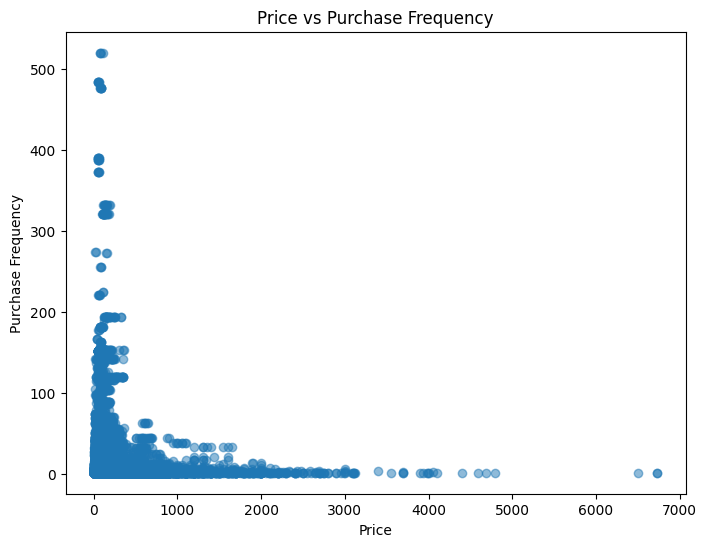

In [193]:
plt.figure(figsize=(8,6))
plt.scatter(df_price_freq['price'], df_price_freq['purchase_frequency'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Purchase Frequency')
plt.title('Price vs Purchase Frequency')
plt.show()

El diagrama de dispersión permite visualizar la relación entre el precio del producto y su frecuencia de compra. Se observa que los productos con precios más bajos tienden a concentrar una mayor frecuencia de compra, mientras que los productos de mayor precio presentan, en general, una menor cantidad de ventas.

In [194]:
df_price_freq['price_range'] = pd.qcut(
    df_price_freq['price'],
    q=4,
    labels=['Low', 'Medium-Low', 'Medium-High', 'High']
)

df_price_freq.groupby('price_range')['purchase_frequency'].mean()

/tmp/ipython-input-3378130338.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_price_freq.groupby('price_range')['purchase_frequency'].mean()


,purchase_frequency
price_range,
Low,4.940877
Medium-Low,7.237599
Medium-High,9.621138
High,6.348590


El análisis bivariante entre el precio y la frecuencia de compra sugiere una relación inversa entre ambas variables. En general, los productos de mayor precio tienden a ser adquiridos con menor frecuencia, mientras que los productos más económicos concentran un mayor volumen de compras. Este comportamiento es consistente con patrones de consumo habituales en comercio electrónico y aporta información relevante para estrategias de precios y gestión de inventario.